In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# Set the split ratio for training and testing data
_split = 0.7

In [21]:
# Load the stock data
data_path = '../../Dataset/VCB.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

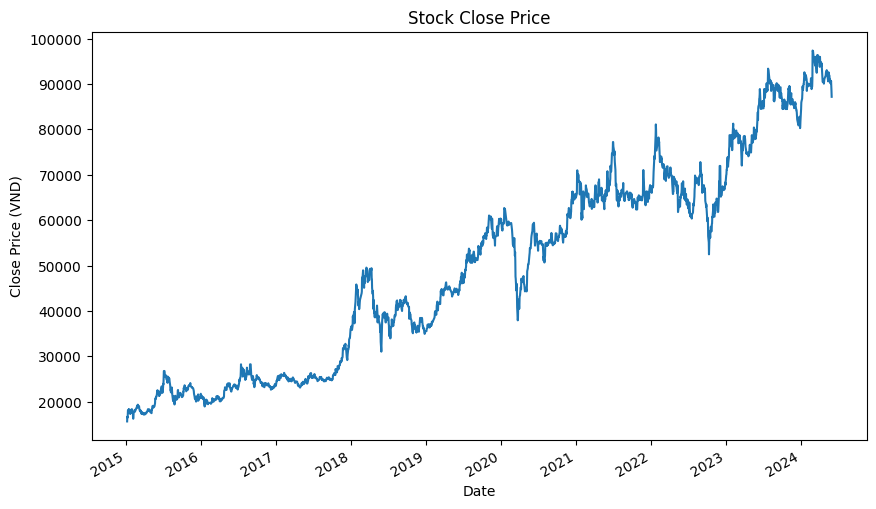

In [22]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [23]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [24]:
# Prepare the data for the RNN
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X, Y = create_dataset(scaled_data, time_step)

In [25]:
# Split the data into training and test sets
train_size = int(len(X) * _split)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [26]:
# Reshape the data to be compatible with RNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [40]:
Y_train

array([0.02345871, 0.02165419, 0.02345871, ..., 0.62827207, 0.62827207,
       0.64288864])

In [27]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Train the model
model.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_test, Y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1751 - val_loss: 0.0061
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9188e-04 - val_loss: 0.0023
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1745e-04 - val_loss: 0.0015
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8134e-04 - val_loss: 0.0017
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0572e-04 - val_loss: 0.0011
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7046e-04 - val_loss: 0.0018
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5547e-04 - val_loss: 0.0011
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8543e-04 - val_loss: 0.0013
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0124e-04 - val_loss: 0.0011
Epoch 12/100
25/25 ━

In [29]:
# Predict on test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [30]:
# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [36]:
# Predict the next 30 days
last_60_days = scaled_data[-time_step:]
next_30_days = []

for _ in range(30):
    next_day = model.predict(last_60_days.reshape(1, time_step, 1))
    next_30_days.append(next_day[0, 0])
    last_60_days = np.append(last_60_days, next_day, axis=0)[1:]

# Inverse transform the predictions
next_30_days = scaler.inverse_transform(np.array(next_30_days).reshape(-1, 1))

# Create a DataFrame to store the predictions
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
future_data = pd.DataFrame(next_30_days, index=future_dates, columns=['Close'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [31]:
# Calculate RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict))
mae = mean_absolute_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)
mape = np.mean(np.abs((scaler.inverse_transform(Y_test.reshape(-1, 1)) - test_predict) / scaler.inverse_transform(Y_test.reshape(-1, 1)))) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 2576.28807276056
MAE: 2201.81401338633
MAPE: 2.809927093325756


In [ ]:
# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(data, train_predict, label='Train Prediction')
plt.plot(data.index[time_step+len(train_predict)+1:len(data)-1], test_predict, label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.show()